In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import convolve
from scipy.interpolate import Rbf
from scipy.interpolate import griddata

In [ ]:

def resize_image(image, max_size=512):
    width, height = image.size
    if max(width, height) > max_size:
        scale_factor = max_size / max(width, height)
        new_width = int(width * scale_factor)
        new_height = int(height * scale_factor)
        image = image.resize((new_width, new_height), Image.ANTIALIAS)
    return image

# Modify the binarize_image function to include resizing


def binarize_image(image_path, threshold=128, max_size=512):
    image = Image.open(image_path).convert('L')
    image = resize_image(image, max_size)
    image = image.point(lambda p: p > threshold and 255)
    return image

# optimization of RBF


def euclidean_norm_numpy(x1, x2):
    return np.linalg.norm(x1 - x2, axis=0)


# def image_to_3d_representation(image, neighborhood_size=3, smooth=1.0):
#     width, height = image.size
#     pixels = np.array(image)

#     kernel = np.ones((neighborhood_size, neighborhood_size))
#     kernel_sum = np.sum(kernel)
#     kernel[kernel == 1] = 1 / kernel_sum

#     convolved = convolve(255 - pixels, kernel, mode='constant', cval=0.0)
#     x, y = np.meshgrid(np.arange(width), np.arange(height))

#     black_pixels = pixels == 0
#     rbf = Rbf(x[black_pixels], y[black_pixels], convolved[black_pixels],
#               smooth=smooth, function='gaussian', norm=euclidean_norm_numpy)
#     z = rbf(x, y)

#     return x, y, z

def image_to_3d_representation(image, neighborhood_size=3, method='cubic'):
    width, height = image.size
    pixels = np.array(image)

    kernel = np.ones((neighborhood_size, neighborhood_size))
    kernel_sum = np.sum(kernel)
    kernel[kernel == 1] = 1 / kernel_sum

    convolved = convolve(255 - pixels, kernel, mode='constant', cval=0.0)
    x, y = np.meshgrid(np.arange(width), np.arange(height))

    black_pixels = pixels == 0
    points = np.column_stack(
        (x[black_pixels].ravel(), y[black_pixels].ravel()))
    values = convolved[black_pixels].ravel()
    grid_x, grid_y = np.mgrid[0:width, 0:height]

    z = griddata(points, values, (grid_x, grid_y), method=method)

    return x, y, z


# Visualize the 3D representation RBF & convolve
# def plot_3d_representation(x, y, z):
#     fig = plt.figure()
#     ax = fig.add_subplot(111, projection='3d')
#     ax.scatter(x, y, z, c=z, cmap='gray')
#     plt.show()

def plot_3d_representation(x, y, z):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    black_pixels = z != 0
    ax.scatter(x[black_pixels], y[black_pixels],
               z[black_pixels], c=z[black_pixels], cmap='gray')

    plt.show()


In [ ]:
# version 2
import numpy as np
from PIL import Image
from scipy.ndimage import convolve
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def resize_image(image, max_size=512):
    width, height = image.size
    if max(width, height) > max_size:
        scale_factor = max_size / max(width, height)
        new_width = int(width * scale_factor)
        new_height = int(height * scale_factor)
        image = image.resize((new_width, new_height), Image.ANTIALIAS)
    return image


def binarize_image(image_path, threshold=128, max_size=512):
    image = Image.open(image_path).convert('L')
    image = resize_image(image, max_size)
    image = image.point(lambda p: p > threshold and 255)
    return image


def image_to_3d_representation(image, neighborhood_size=3, method='cubic'):
    width, height = image.size
    pixels = np.array(image)

    kernel = np.ones((neighborhood_size, neighborhood_size))
    kernel_sum = np.sum(kernel)
    kernel[kernel == 1] = 1 / kernel_sum

    convolved = convolve(255 - pixels, kernel, mode='constant', cval=0.0)
    x, y = np.meshgrid(np.arange(width), np.arange(height))

    black_pixels = pixels == 0
    points = np.column_stack((x[black_pixels].ravel(), y[black_pixels].ravel()))
    values = convolved[black_pixels].ravel()
    grid_x, grid_y = np.mgrid[0:width, 0:height]

    z = griddata(points, values, (grid_x, grid_y), method=method)
    z[np.isnan(z)] = 0  # Replace NaN values with zeros

    return x, y, z


def plot_3d_representation(x, y, z, pixels):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    black_pixel_indices = np.where(pixels == 0)
    x_black_pixels = x[black_pixel_indices]
    y_black_pixels = y[black_pixel_indices]
    z_black_pixels = z[black_pixel_indices]

    ax.scatter(x_black_pixels, y_black_pixels, z_black_pixels, c=z_black_pixels, cmap='gray')

    plt.show()



In [ ]:
image_path = 'synthetic_tables/table_image_1.png'
binarized_image = binarize_image(image_path)
pixels = np.array(binarized_image)
x, y, z = image_to_3d_representation(binarized_image, neighborhood_size=2)

x.shape, y.shape, z.shape

In [ ]:
plot_3d_representation(x, y, z.T, pixels)

In [ ]:
import numpy as np
from numpy.polynomial import Polynomial
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

def fit_polynomial_surface(x, y, z, degree=2):
    points = np.column_stack((x.ravel(), y.ravel()))
    model = Pipeline([
        ('poly', PolynomialFeatures(degree=degree)),
        ('linear', LinearRegression(fit_intercept=False))
    ])
    model.fit(points, z.ravel())
    
    z_fit = model.predict(points).reshape(z.shape)
    return z_fit


In [ ]:
# x, y, z = image_to_3d_representation(binarized_image, neighborhood_size=2)
z_fit = fit_polynomial_surface(x, y, z, degree=3*5)
plot_3d_representation(x, y, z_fit.T, pixels)


In [ ]:
plt.imshow(binarized_image, cmap='gray')
plt.xticks([]), plt.yticks([])
plt.axis('off')
plt.show()

In [1]:
# version 3
%matplotlib widget

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def resize_image(image, max_size=512):
    width, height = image.size
    if max(width, height) > max_size:
        scale_factor = max_size / max(width, height)
        new_width = int(width * scale_factor)
        new_height = int(height * scale_factor)
        image = image.resize((new_width, new_height), Image.ANTIALIAS)
    return image

def image_to_grayscale(image_path, max_size=512):
    image = Image.open(image_path).convert('L')
    image = resize_image(image, max_size)
    return image

def image_to_3d_structure(grayscale_image):
    width, height = grayscale_image.size
    pixel_matrix = np.array(grayscale_image)
    
    max_intensity = np.max(pixel_matrix)
    z = max_intensity - pixel_matrix
    
    x, y = np.meshgrid(np.arange(width), np.arange(height))
    
    return x, y, z[::-1]

def plot_3d_structure(x, y, z):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x, y, z, cmap='gray', antialiased=True)
    plt.show()

# image_path = 'synthetic_tables/table_image_1.png'
image_path = 'data/GOZ_demo.png'
grayscale_image = image_to_grayscale(image_path, max_size=1024)
x, y, z = image_to_3d_structure(grayscale_image)



/var/folders/hm/j4vjw44n4k99t0758zmc1h0r0000gn/T/ipykernel_2281/2199374391.py:15: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize((new_width, new_height), Image.ANTIALIAS)


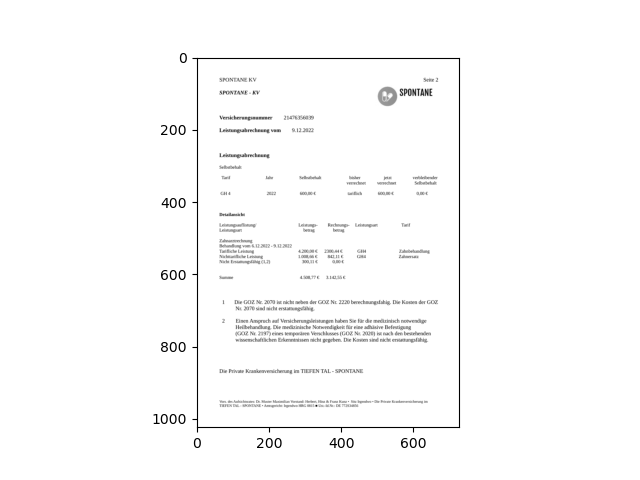

In [2]:
plt.imshow(grayscale_image, cmap='gray')
plt.show()

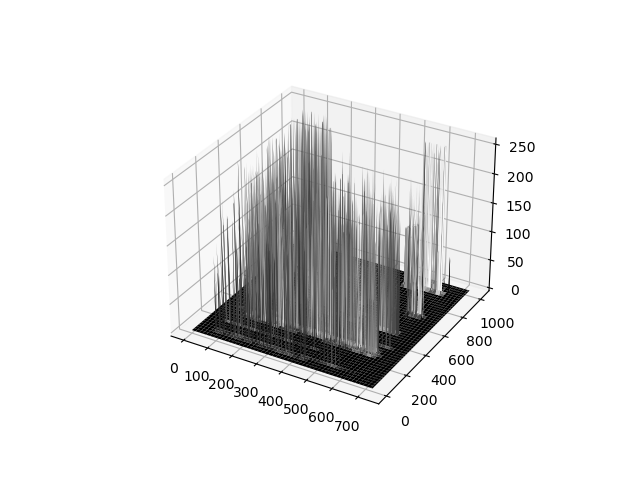

In [3]:
plot_3d_structure(x, y, z)

In [5]:
import numpy as np
from skimage.feature import peak_local_max


def extract_features(z, min_distance=5, threshold_abs=None):
    local_maxima = peak_local_max(z, min_distance=min_distance, threshold_abs=threshold_abs)
    gradient_x, gradient_y = np.gradient(z)

    features = []
    for x, y in local_maxima:
        intensity = z[x, y]
        gradient = (gradient_x[x, y], gradient_y[x, y])
        feature = (x, y, intensity, gradient[0], gradient[1])
        features.append(feature)

    return np.array(features)

features = extract_features(z)  # Extract features
features.shape


(987, 5)

In [7]:
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage

def perform_hierarchical_clustering(features):
    distance_matrix = pdist(features, metric='euclidean')
    linkage_matrix = linkage(distance_matrix, method='ward')
    return linkage_matrix

linkage_matrix = perform_hierarchical_clustering(features)  # Perform hierarchical clustering
linkage_matrix.shape


(986, 4)

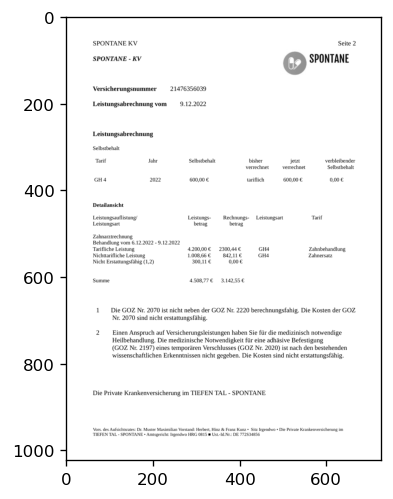

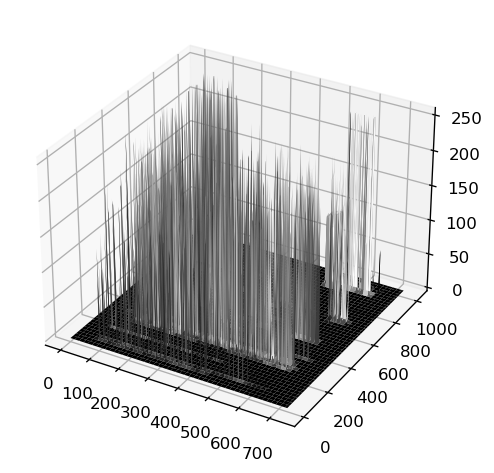

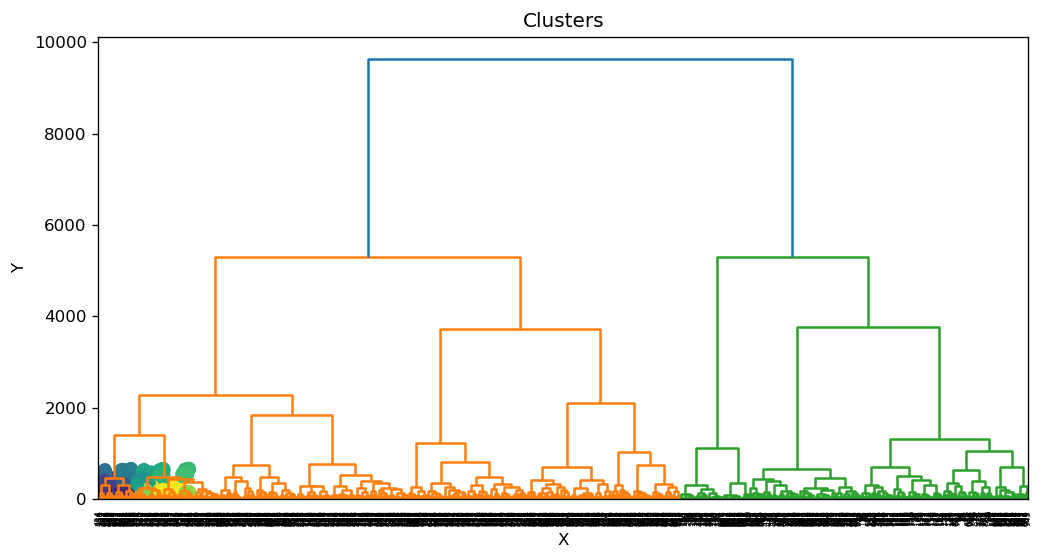

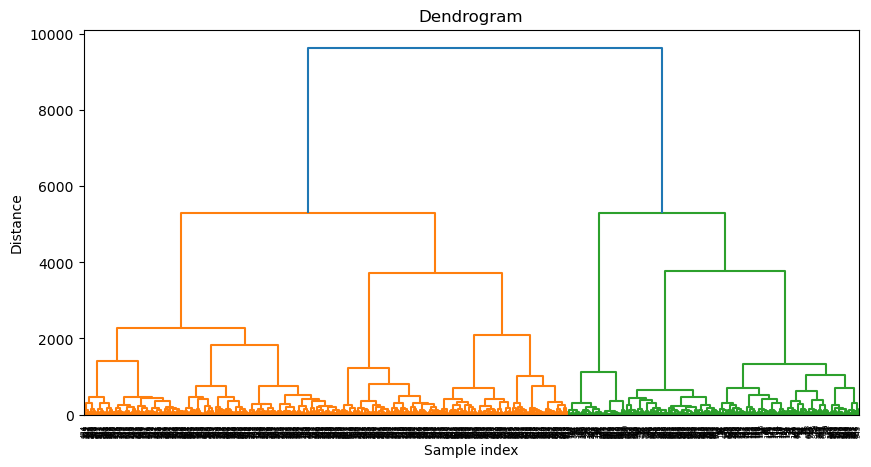

In [10]:
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 5))
dendrogram(linkage_matrix, ax=ax)
ax.set_title('Dendrogram')
ax.set_xlabel('Sample index')
ax.set_ylabel('Distance')

plt.show()


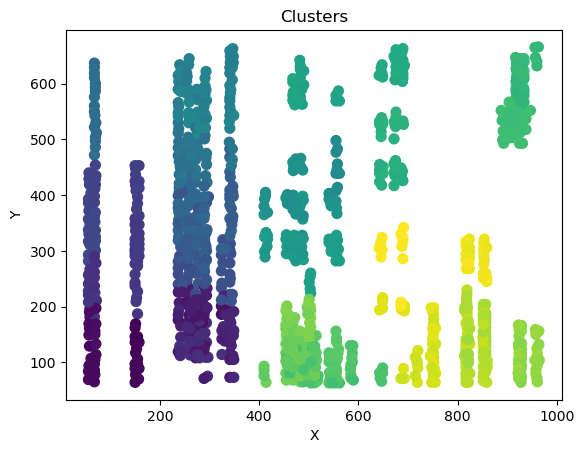

In [11]:
from scipy.cluster.hierarchy import fcluster

threshold_distance = 20 # adjust
cluster_labels = fcluster(linkage_matrix, threshold_distance, criterion='distance')

plt.scatter(features[:, 0], features[:, 1], c=cluster_labels, cmap='viridis', s=50)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Clusters')
plt.show()

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize


def find_similar_regions(features1, features2, similarity_threshold=0.8):
    features1_normalized = normalize(features1, axis=0)
    features2_normalized = normalize(features2, axis=0)

    similarity_matrix = cosine_similarity(features1_normalized, features2_normalized)
    similar_region_pairs = []
    for i, feature1 in enumerate(features1):
        for j, feature2 in enumerate(features2):
            if similarity_matrix[i, j] >= similarity_threshold:
                similar_region_pairs.append((feature1, feature2))

    return similar_region_pairs

# Examples
x1, y1, z1 = image_to_3d_structure(grayscale_image1)
features1 = extract_features(z1)

x2, y2, z2 = image_to_3d_structure(grayscale_image2)
features2 = extract_features(z2)

similar_regions = find_similar_regions(features1, features2)


In [ ]:
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage


def extract_features(x, y, z):
    # Extract features from the 3D structure
    pass


def perform_hierarchical_clustering(features):
    # Perform hierarchical clustering on the features
    distance_matrix = pdist(features, metric='euclidean')
    linkage_matrix = linkage(distance_matrix, method='ward')
    return linkage_matrix


def find_similar_regions(linkage_matrix, user_marked_region, similarity_threshold):
    # Find similar regions based on the user-marked region
    pass


def locate_patterns(linkage_matrix, user_marked_region, similarity_threshold):
    # Locate the pattern in other documents
    similar_regions = find_similar_regions(linkage_matrix, user_marked_region, similarity_threshold)
    pass

In [ ]:
# version 4
import numpy as np
from PIL import Image


def image_to_3d_structure(grayscale_image):
    width, height = grayscale_image.size
    pixel_matrix = np.array(grayscale_image)

    max_intensity = np.max(pixel_matrix)
    z = np.zeros_like(pixel_matrix, dtype=float)

    # Initialize the "moving" matrix with max_intensity values
    moving_matrix = np.full_like(pixel_matrix, max_intensity)

    for i in range(height):
        for j in range(width):
            # Update the z value at (i, j) based on the moving_matrix value before decreasing it
            z[i, j] = moving_matrix[i, j] - pixel_matrix[i, j]

            # Propagate the change to the rest of the row
            moving_matrix[i, j:] -= pixel_matrix[i, j]

    x, y = np.meshgrid(np.arange(width), np.arange(height))

    return x, y, z



image_path = 'synthetic_tables/table_image_1.png'
grayscale_image = image_to_grayscale(image_path, max_size=512)
x, y, z = image_to_3d_structure(grayscale_image)
plot_3d_structure(x, y, z)
